In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools 
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import datajoint as dj
from collections import defaultdict
import pycircstat as pycs
from funconnect import morphology, connectomics, ta3, nda
from tqdm import tqdm
import scipy.stats as stats


Connecting celiib@10.28.0.34:3306


In [2]:
#setting the address and the username
dj.config['database.host'] = '10.28.0.34'
dj.config['database.user'] = 'celiib'
dj.config['database.password'] = 'newceliipass'
dj.config['safemode']=True
dj.config["display.limit"] = 20


pinky = dj.create_virtual_module('pinky', 'microns_pinky')
pinky_nda = dj.create_virtual_module('pinky_nda', 'microns_pinky_nda')
radtune = dj.create_virtual_module('pinky_radtune', 'microns_pinky_radtune')
spattune = dj.create_virtual_module('pinky_spattune', 'microns_pinky_spattune')
fc = dj.create_virtual_module('pinky_fc', 'microns_pinky_fc')


In [3]:
"""
WHERE THE RF CORRELATION BINS ARE EXPLICITELY SET
"""

attrs = ['segment_a', 'segment_b', 'connection', 'n_seg_shared']
good_rf = 'mscore > 1.50'

rf_bin_edges = np.linspace(-.7, .7, 6) #setting the bin boundaries


"""
Calculate the bins and centers for the orientational preference
"""
#defines how to find the "tuned" segments of the orientation
dori_resolution = np.pi / 2 / 4 #setting the width size of the bins to be 22.5 degrees
rad2deg = 180/np.pi
bin_edges = np.linspace(0, np.pi,9) #creates 8 bins between boundaries between 0 and pi


In [33]:
def mean_conversion_marginal_orientation(stats_choice,rf_bin_edges,ori_bin_edges,
                   n_seg_shared_threshold = 10,
                    n_seg_shared_converted_threshold = 0,
                   ori_confidence=0.5,
                   von_p_value=0.05):
    
    
    # mean_conversion_marginal_orientation(["perc_90_mean_conversion"],
    #                rf_bin_edges=rf_bin_edges,
    #                ori_bin_edges=bin_edges,
    #               n_seg_shared_threshold = 10,
    #               n_seg_shared_converted_threshold = 0)


    # stats_choice = ["perc_90_mean_conversion"]
    # rf_bin_edges = rf_bin_edges
    # ori_bin_edges=bin_edges
    # n_seg_shared_threshold = 10
    # n_seg_shared_converted_threshold = 0
    # ori_confidence=0.5
    # von_p_value=0.05

    synapse = (pinky.Synapse - pinky.SynapseExclude) & pinky.CurrentSegmentation
    segment = (pinky.Segment - pinky.SegmentExclude) & pinky.CurrentSegmentation
    soma = (pinky.AllenSoma - pinky.SegmentExclude) & pinky.CurrentSegmentation
    soma = soma & "cell_class='excitatory'"

    """calculate the specifics for the bins based on the bin edges given"""
    ###Receptive Field
    #calculates the centers of the bins used for the receptive field
    cbin_centers = np.hstack((np.nan, np.round((rf_bin_edges[1:] + rf_bin_edges[:-1])/2, decimals=2), np.nan))
    #creates labels for the receptive field edges
    cbin_labels = ['[{:.1f},{:.1f}]'.format(*a) for a in zip(rf_bin_edges[:-1], rf_bin_edges[1:])]


    ###Orientation
    rad2deg = 180/np.pi
    # turns all of the bin edges into degrees with no decimal
    be = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in ori_bin_edges]])
    #creates the bin boundary markings with [low - high]
    bin_labels = list(zip(be[:-1], be[1:]))

    #calculates the bin centers
    bin_centers = np.round((ori_bin_edges[1:] + ori_bin_edges[:-1])/2 * rad2deg, decimals=2)


    """
    Gets the segments with the acceptable rf thresholds
    """

    # functional metrics for each functional soma pair (restricting by spattune fitting significance)

    sig_units_rf = spattune.BestSTA.Loc & 'sta_snr > 1.25' & segment
    sig_unit_pairs_rf = (sig_units_rf.proj(segment_id1 = 'segment_id') * 
                      sig_units_rf.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

    print("Number of significant receptive field neurons = " + str(len(sig_units_rf)))

    rf_table = (spattune.BestSTACorr.proj(rf_corr_coef="union_corr_r2",
                              segment_a="segment_id1",segment_b="segment_id2")
                              & sig_units_rf.proj(segment_a="segment_id") &
                              sig_units_rf.proj(segment_b="segment_id"))
    print("Length of rf correlation = " + str(len(rf_table)))

    """
    build the pref_rel table to use for the orinetation data

    This table just needs the 
    1) segment_id
    2) von_r2 (orientation preference)
    --> for all of the tuned segments
    """
    tuned = 'confidence > ' + str(ori_confidence)
    #get the significantly tuned segments
    sig_units_op = radtune.BestVonFit.Unit & 'von_p_value <= ' + str(von_p_value) & tuned & segment
    print("Number of significanlty orientationally tuned neurons = " + str(len(sig_units_op)))


    #gets the significantly tuned neurons and their differences in combinational pairs 
    sig_unit_pairs_op = (radtune.BestVonCorr() & sig_units_op.proj(segment_id1="segment_id") 
                     & sig_units_op.proj(segment_id2="segment_id")).proj("diff_pref_ori")

    sig_unit_pairs_op = sig_unit_pairs_op.proj(segment_a="segment_id1",
                                               segment_b="segment_id2",
                                               dori="diff_pref_ori")

    print("Length of pairwise orientation difference table = " + str(len(sig_unit_pairs_op)))


    """
    goes and applies the restrictions and then gets the desired stat
    binary_conv_jaccard_ones_ratio=null : float                        # a / (a + b + c  + d) for jaccard similarity of binary conversion rate
    binary_conv_jaccard_matching_ratio=null : float                        # ( a + d )/ (a + b + c  + d) for jaccard similarity of binary conversion rate


    Examples of Possible stats: 
    "n_seg_shared_converted",
    "binary_conversion_pearson",
    "binary_conv_jaccard_ones_ratio",
    "conversion_pearson",
    "density_pearson",
    "synapse_vol_density_pearson",
    "synapse_vol_density_cosine",
    "binary_conversion_pearson_converted",
    "binary_conv_jaccard_ones_ratio_converted",
    "conversion_pearson_converted",
    "density_pearson_converted",
    "synapse_vol_density_pearson_converted",
    "synapse_vol_density_cosine_converted",

    """

    stats_choice_original = stats_choice.copy()

    #remove number of segments shared if already there
    if "n_seg_shared" in stats_choice:
        stats_choice.remove("n_seg_shared")



    sign_contact_correlations_only_shared_threshold = fc.ContactMeanStatistics() & "n_seg_shared>" + str(n_seg_shared_threshold)
    print("sign_contact_correlations_only_shared_threshold = " + str(len(sign_contact_correlations_only_shared_threshold)))
    sign_contact_correlations = sign_contact_correlations_only_shared_threshold & "n_seg_shared_converted>" + str(n_seg_shared_converted_threshold)
    print("sign_contact_correlations with both shared number threshold and shared number converted threshold = " + str(len(sign_contact_correlations)))
    sign_contact_correlations = sign_contact_correlations.proj(*stats_choice,
                                                               segment_a="segment_id",
                                                               n_seg_shared_contacts="n_seg_shared",

                                                              )

    """gets table where have every connection from segment_a to segment b anf the number of n_seg_shared stacked on a 
    repeat but the ids for a and b are switched  """
    shi = fc.SharedInput.proj("n_seg_shared",segment_a="segment_id")

    print("len(shi) = " + str(len(shi)))
    print("len(shi restricted by the contact correlations with n_seg_shared threshold) = " + str(len(shi & sign_contact_correlations_only_shared_threshold.proj(segment_a="segment_id"))))
    print("len(shi restricted by the contact correlations with n_seg_shared threshold AND converted threshold) = " + str(len(shi & sign_contact_correlations)))

    new_shi = shi * sign_contact_correlations

    """ takes all of the possible shared input combinations:
    1) gets this correlation table and renames seg a and b and uses that to restrict the shared input combinations and attach the rf correlation
    2) Further restricts to only those TUNED with prefered orientation (and adds on the orientation for a and b)
    3) Restrict to only significant rective fields for both segment A and B by DOES NOT ATTACH THE RF score

    """
    crel = shi * rf_table * sig_unit_pairs_op
    new_crel =  new_shi * rf_table * sig_unit_pairs_op
    print((len(crel),len(new_crel)))
    crel = new_crel

    """Pulls down the data and starts doing pandas altering"""
    cdf = pd.DataFrame(crel.fetch())
    #drop any rows with nans
    cdf = cdf.dropna()

    #gets the bins of the correlations of the receptive fields
    cdf['bcorr'] = cbin_centers[(np.digitize(cdf['rf_corr_coef'], rf_bin_edges))]
    #makes the bins of the corelation of the receptive fields as floats
    cdf['bcorr'] = np.array(cdf['bcorr']).astype(float)
    #bins the difference in orientation
    cdf['bdori'] = bin_centers[(np.digitize(np.abs(cdf["dori"]), ori_bin_edges))-1]


    #makes the stats all floats
    for s in stats_choice_original:
        cdf[s] = np.array(cdf[s]).astype(float)


    for s in stats_choice_original:  
        ax = sns.pointplot('bdori',s, data = cdf) 
        ax.set_title(s + ' vs. Difference in Orientation bin')
        ax.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
        ax.set_xlabel(r'$\Delta \theta$')
        ax.set_ylabel('$<' + s + '>$')

    sns.despine(trim=True)

#     with sns.axes_style('ticks'):
#         fig, ax = plt.subplots(len(s), 1, figsize=(15, 5))
    
#     #now iterate through and do allof the graphs for every stat requested and display bin values
#     for i,s in enumerate(stats_choice_original):
#             #groups the pairs by the binned directional orientation and gets the mean of the number of shared segments

#         sns.pointplot('bdori',s, data = cdf,ax=ax[i]) 
#         ax[i].set_title(s + ' vs. Difference in Orientation bin')
#         ax[i].set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
#         ax[i].set_xlabel(r'$\Delta \theta$')
#         ax[i].set_ylabel('$<' + s + '>$')
    
#     sns.despine(trim=True)
#     fig.tight_layout()





    #     #now iterate through and do allof the graphs for every stat requested and display bin values
    #     for s in stats_choice_original:

    #         #calculates the actual histograms
    #         gs = plt.GridSpec(1,2)
    #         fig = plt.figure(figsize=(13,7.5))
    #         ax_heat_shared = fig.add_subplot(gs[0,0])

    #         #groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
    #         df2  = cdf
    #         df2 = df2.groupby(['bdori', 'bcorr'])[s].mean().reset_index()
    #         #turns the pairs into a pivot table that can be visualized as a heatmap
    #         df2 = df2.pivot('bdori', 'bcorr', s)
    #         #graphs the heat map
    #         g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2,ax=ax_heat_shared)
    #         #applys the y labels for the shared segments (have to format it so they will show the degrees)
    #         g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
    #         #sets the rf labels and rotates them slightly
    #         g.set_xticklabels(cbin_labels, rotation=30)
    #         #inverts the y axis so that they are going up in value as graph goes up
    #         g.invert_yaxis()
    #         #sets no tick marks
    #         g.tick_params(length=0)
    #         #set labels
    #         g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
    #         g.set_ylabel(r'$\langle$shared segments$\rangle$')
    #         g.set_title('Average ' + str(s) +  "\n shared_threshold = " + str(n_seg_shared_threshold) + ", \n converted shared_threshold = " + str(n_seg_shared_converted_threshold))

    #         ax_heat_count = fig.add_subplot(gs[0,1])

    #         #groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
    #         df2  = cdf
    #         df2 = df2.groupby(['bdori'])[s].count().reset_index()
    #         #turns the pairs into a pivot table that can be visualized as a heatmap
    #         df2 = df2.pivot('bdori', 'bcorr', s)
    #         #graphs the heat map
    #         g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2,ax=ax_heat_count,fmt='g')
    #         #applys the y labels for the shared segments (have to format it so they will show the degrees)
    #         g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
    #         #sets the rf labels and rotates them slightly
    #         g.set_xticklabels(cbin_labels, rotation=30)
    #         #inverts the y axis so that they are going up in value as graph goes up
    #         g.invert_yaxis()
    #         #sets no tick marks
    #         g.tick_params(length=0)
    #         #set labels
    #         g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
    #         g.set_ylabel(r'$\langle$Number of pairs in bin$\rangle$')

    #         #Add title based on all the parameters

    #         # g.set_title('add title here')
    #         g.set_title('Number of pairs in bins')
    #         plt.show()



    
    
    



In [26]:
cdf

,segmentation,segment_a,segment_b,sta_hash1,sta_hash2,apert_radius,von_hash1,von_hash2,n_seg_shared,n_seg_shared_contacts,perc_90_mean_conversion,rf_corr_coef,dori,bcorr,bdori
0,3,648518346341366913,648518346341367107,b7a191fac5a9ce85d6257f222515cc3f,1c15ba3fbf5378c195b38f40587eea64,20,44474bbe7b563dc5dee23b57fddb34e9,e83a2710d7a882bf349398e194eb5fb5,0,56,0.500000,-0.547090,0.024569,-0.56,11.25
1,3,648518346341366913,648518346342788331,b7a191fac5a9ce85d6257f222515cc3f,10a1c7cbde09b5b1ee60ff3add7bc8e1,20,44474bbe7b563dc5dee23b57fddb34e9,d15efca26c4602a284574cdf2b2cf34d,0,23,0.200000,0.836038,-1.179450,NaN,78.75
2,3,648518346341366913,648518346342798923,b7a191fac5a9ce85d6257f222515cc3f,cfc50cc35a2ac22f15cc2326712270bc,20,44474bbe7b563dc5dee23b57fddb34e9,b66dd1fb8f894dfc6b5f15407a0508e0,0,20,0.000000,0.140674,0.484912,0.28,33.75
3,3,648518346341366913,648518346342915230,b7a191fac5a9ce85d6257f222515cc3f,80e480c3f56a6f525d4c87b715578599,20,44474bbe7b563dc5dee23b57fddb34e9,e0e8697e5a17345372086924dadc0f59,0,30,0.000000,-0.041187,-1.535740,-0.00,78.75
4,3,648518346341366913,648518346343624383,b7a191fac5a9ce85d6257f222515cc3f,8bd7c2990a891e961d60c9e260348327,20,44474bbe7b563dc5dee23b57fddb34e9,820731dbddcd2b47966983e2fd032961,0,19,0.000000,0.075910,-0.867979,-0.00,56.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180,3,648518346349511528,648518346349512869,6b4f7700056323ae485bb8dc9c7f9791,41e4b1c2790100f8c942daaf633f8d2b,20,0427999279dd6571f0dc76dde8da95a4,e919798a1aefa68a9f3512c13ebbaf39,54,6996,0.333333,-0.005982,0.044026,-0.00,11.25
2181,3,648518346349511528,648518346349513012,6b4f7700056323ae485bb8dc9c7f9791,fe2765213885d2fb43fafaa52a5defc0,20,0427999279dd6571f0dc76dde8da95a4,9348cd57608593dbc8cb78c30a50c6a8,46,5175,0.500000,0.011679,1.068060,-0.00,56.25
2182,3,648518346349511983,648518346349512869,9ebe5168a1d235dc835853e5adb0b05e,41e4b1c2790100f8c942daaf633f8d2b,20,5b26a8c1d36bb7a5f567b5bff04d2df6,e919798a1aefa68a9f3512c13ebbaf39,92,7673,0.250000,-0.353391,0.764857,-0.28,33.75
2183,3,648518346349511983,648518346349513012,9ebe5168a1d235dc835853e5adb0b05e,fe2765213885d2fb43fafaa52a5defc0,20,5b26a8c1d36bb7a5f567b5bff04d2df6,9348cd57608593dbc8cb78c30a50c6a8,24,4342,0.500000,0.393256,-1.352700,0.28,78.75


In [25]:
# mean_conversion_marginal_orientation(["perc_90_mean_conversion",
#                                       "perc_80_mean_conversion",
#                                       "perc_70_mean_conversion",
#                                       "mean_mean_conversion_converted",
#                                       "median_mean_conversion"],

#now iterate through and do allof the graphs for every stat requested and display bin values
# for s in stats_choice_original:
#         #groups the pairs by the binned directional orientation and gets the mean of the number of shared segments

ax =sns.pointplot('bdori',"perc_80_mean_conversion", data = cdf) 
ax.set_title('90 percentile means vs. Difference in Orientation bin')
ax.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
ax.set_xlabel(r'$\Delta \theta$')
ax.set_ylabel('$<90 percentile of means>$')
sns.despine(trim=True)


ValueError: Could not interpret input 'perc_80_mean_conversion'

In [18]:
fc.ContactMeanStatistics()

segmentation segmentation id,segment_id segment id unique within each Segmentation,segment_b id of the postsynaptic neuron,n_seg_a n_presyns contacting onto segment_id,n_seg_b n_presyns contacting onto segment_b,n_seg_shared n_presyns contacting onto both segment_id and segment_b,n_seg_shared_converted n_presyns contacting onto both and converting on at least 1 postsyn,n_seg_a_converted n_presyns contacting onto both and converting on postsyna a,n_seg_b_converted n_presyns contacting onto both and converting on postsyna b,perc_90_mean_conversion pearson correlation for binary n_synapse/n_contact rate,perc_80_mean_conversion pearson correlation for binary n_synapse/n_contact rate,perc_70_mean_conversion pearson correlation for binary n_synapse/n_contact rate,mean_mean_conversion pearson correlation for binary n_synapse/n_contact rate,median_mean_conversion pearson correlation for binary n_synapse/n_contact rate,perc_90_mean_conversion_converted pearson correlation for binary n_synapse/n_contact rate,perc_80_mean_conversion_converted pearson correlation for binary n_synapse/n_contact rate,perc_70_mean_conversion_converted pearson correlation for binary n_synapse/n_contact rate,mean_mean_conversion_converted pearson correlation for binary n_synapse/n_contact rate,median_mean_conversion_converted pearson correlation for binary n_synapse/n_contact rate
3,648518346341353574,648518346341356241,197,37,36,10,5,6,0.5,0.25,0.0,0.125,0.0,0.525,0.5,0.5,0.45,0.5
3,648518346341353574,648518346341356256,197,8183,9,2,2,0,0.3,0.1,0.0,0.0833333,0.0,0.475,0.45,0.425,0.375,0.375
3,648518346341353574,648518346341357933,197,1674,0,0,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,648518346341353574,648518346341359123,197,2617,3,2,0,2,0.45,0.4,0.35,0.25,0.25,0.475,0.45,0.425,0.375,0.375
3,648518346341353574,648518346341361837,197,364,18,4,2,3,0.5,0.15,0.0,0.125,0.0,0.85,0.7,0.55,0.5625,0.5
3,648518346341353574,648518346341361981,197,5506,9,1,1,0,0.05,0.0,0.0,0.0277778,0.0,0.25,0.25,0.25,0.25,0.25
3,648518346341353574,648518346341362771,197,307,0,0,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,648518346341353574,648518346341362995,197,4722,7,1,0,1,0.2,0.0,0.0,0.0714286,0.0,0.5,0.5,0.5,0.5,0.5
3,648518346341353574,648518346341363182,197,1299,3,0,0,0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan,nan,nan
3,648518346341353574,648518346341366161,197,2520,3,0,0,0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan,nan,nan


In [ ]:
"perc_90_mean_conversion",
"perc_70_mean_conversion",
"mean_mean_conversion_converted",
"median_mean_conversion"

Number of significant receptive field neurons = 199
Length of rf correlation = 19701
Number of significanlty orientationally tuned neurons = 299
Length of pairwise orientation difference table = 44551
sign_contact_correlations_only_shared_threshold = 21990
sign_contact_correlations with both shared number threshold and shared number converted threshold = 21500
len(shi) = 314028
len(shi restricted by the contact correlations with n_seg_shared threshold) = 21860
len(shi restricted by the contact correlations with n_seg_shared threshold AND converted threshold) = 21400
(3081, 2185)


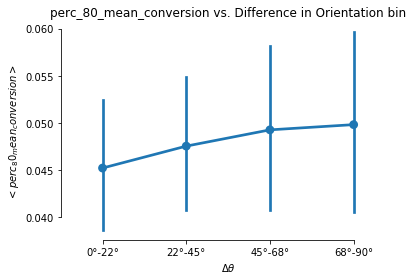

In [34]:
mean_conversion_marginal_orientation([
                                      "perc_80_mean_conversion",
                                      ],
               rf_bin_edges=rf_bin_edges,
               ori_bin_edges=bin_edges,
              n_seg_shared_threshold = 10,
              n_seg_shared_converted_threshold = 0)

Number of significant receptive field neurons = 199
Length of rf correlation = 19701
Number of significanlty orientationally tuned neurons = 299
Length of pairwise orientation difference table = 44551
sign_contact_correlations_only_shared_threshold = 21990
sign_contact_correlations with both shared number threshold and shared number converted threshold = 21500
len(shi) = 314028
len(shi restricted by the contact correlations with n_seg_shared threshold) = 21860
len(shi restricted by the contact correlations with n_seg_shared threshold AND converted threshold) = 21400
(3081, 2185)


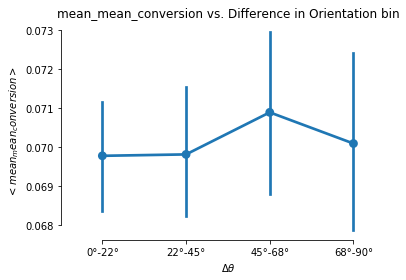

In [35]:
mean_conversion_marginal_orientation([
                                      "mean_mean_conversion",
                                      ],
               rf_bin_edges=rf_bin_edges,
               ori_bin_edges=bin_edges,
              n_seg_shared_threshold = 10,
              n_seg_shared_converted_threshold = 0)

Number of significant receptive field neurons = 199
Length of rf correlation = 19701
Number of significanlty orientationally tuned neurons = 299
Length of pairwise orientation difference table = 44551
sign_contact_correlations_only_shared_threshold = 21990
sign_contact_correlations with both shared number threshold and shared number converted threshold = 21500
len(shi) = 314028
len(shi restricted by the contact correlations with n_seg_shared threshold) = 21860
len(shi restricted by the contact correlations with n_seg_shared threshold AND converted threshold) = 21400
(3081, 2185)


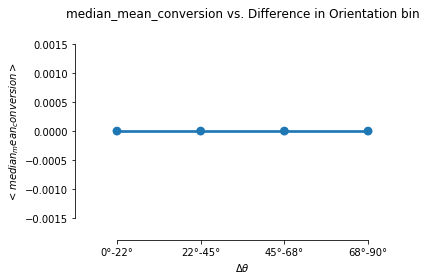

In [36]:
mean_conversion_marginal_orientation([
                                      "median_mean_conversion",
                                      ],
               rf_bin_edges=rf_bin_edges,
               ori_bin_edges=bin_edges,
              n_seg_shared_threshold = 10,
              n_seg_shared_converted_threshold = 0)

# Doing the Center Distance vs. Shared Input